In [22]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime 

LOWER_THRESHOLD = 5

Source of data https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [23]:
data = pd.read_csv('./data/data.csv')
data.head()

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
0,3/11/20,Afghanistan,3,0,AF,NaN,Non-EU/EEA
1,3/8/20,Afghanistan,3,0,AF,NaN,Non-EU/EEA
2,3/2/20,Afghanistan,0,0,AF,NaN,Non-EU/EEA
3,3/1/20,Afghanistan,0,0,AF,NaN,Non-EU/EEA
4,2/29/20,Afghanistan,0,0,AF,NaN,Non-EU/EEA


Outbreaks occur at differnt times in different countries. 
To be able to compare trajectories, day 0 for each country is considered the day,
when there were more than `LOWER_THRESHOLD` cases registered .

In [24]:
def pre_process(data):    
    data['date'] = data['DateRep'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
    data = data.sort_values(by=['CountryExp', 'date'])
    countries = data['CountryExp'].unique()
    stepData = []

    for country in countries:
        ind = 0
        total = 0
        total_deceased = 0
        for _, row in data[data.CountryExp == country].iterrows():        
            total += row['NewConfCases']
            total_deceased += row['NewDeaths']
            if row['NewConfCases'] > 5:
                stepData.append({
                    'country': country,
                    'total': total,
                    'new': row['NewConfCases'],
                    'new_deceased': row['NewDeaths'],
                    'total_deceased': total_deceased,
                    'days': ind
                })

                ind += 1

    df = pd.DataFrame(stepData, columns=['country', 'new', 'total', 'days', 'new_deceased', 'total_deceased'])
    
    return df

In [25]:
df = pre_process(data)
df.head()

,country,new,total,days,new_deceased,total_deceased
0,Albania,12,23,0,0,1
1,Algeria,7,12,0,0,0
2,Argentina,6,8,0,0,0
3,Argentina,7,19,1,0,1
4,Argentina,12,31,2,0,1


In [26]:
def plot_countries(df, metric, *countries):
    colors = list(matplotlib.colors.BASE_COLORS.keys())
    fig, ax = plt.subplots()
    
    for index, country in enumerate(countries):
        data = df[df.country == country]
        ax.plot(data.days, data[metric], label=country)
    
    fig.set_size_inches(18.5, 10.5)
    legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.show()

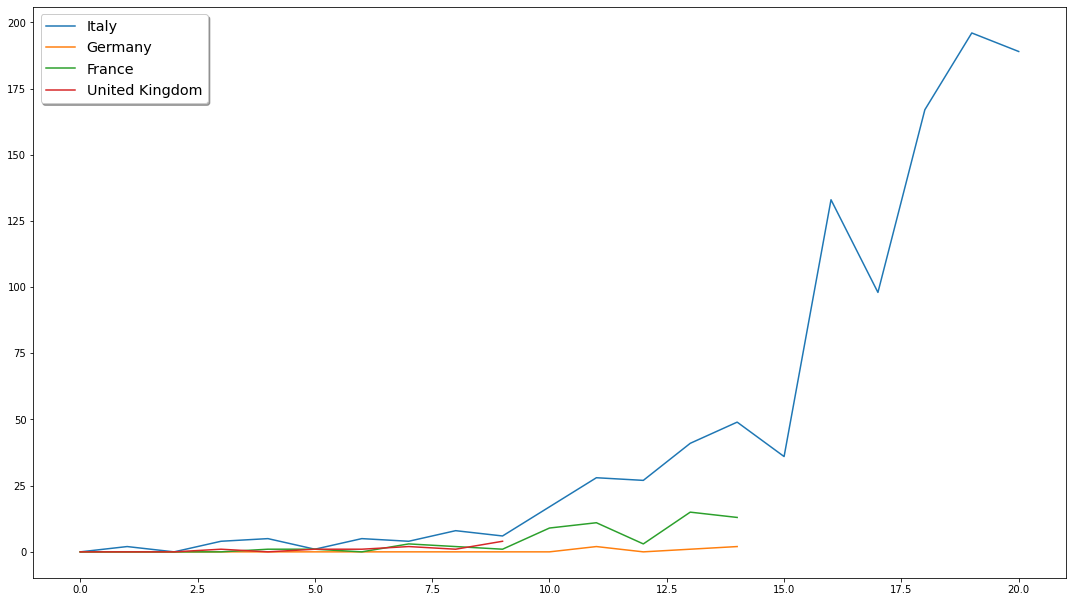

In [30]:
plot_countries(df, 'new_deceased', 'Italy', 'Germany', 'France', 'United Kingdom')

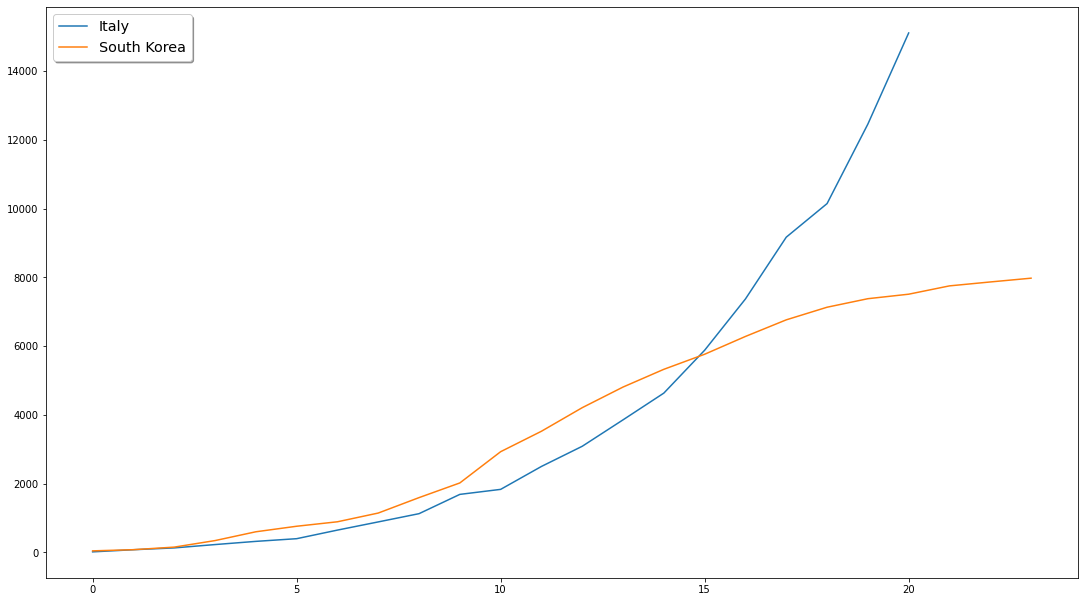

In [31]:
plot_countries(df, 'total', 'Italy', 'South Korea')

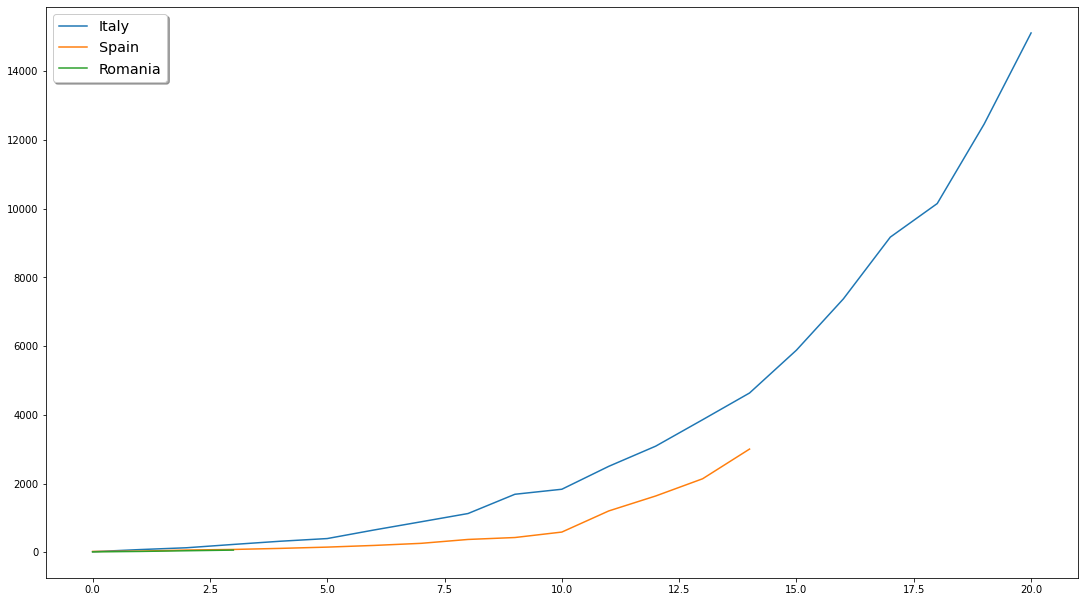

In [32]:
plot_countries(df, 'total', 'Italy', 'Spain', 'Romania')